In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [3]:
data = pd.read_csv("./data/housing.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

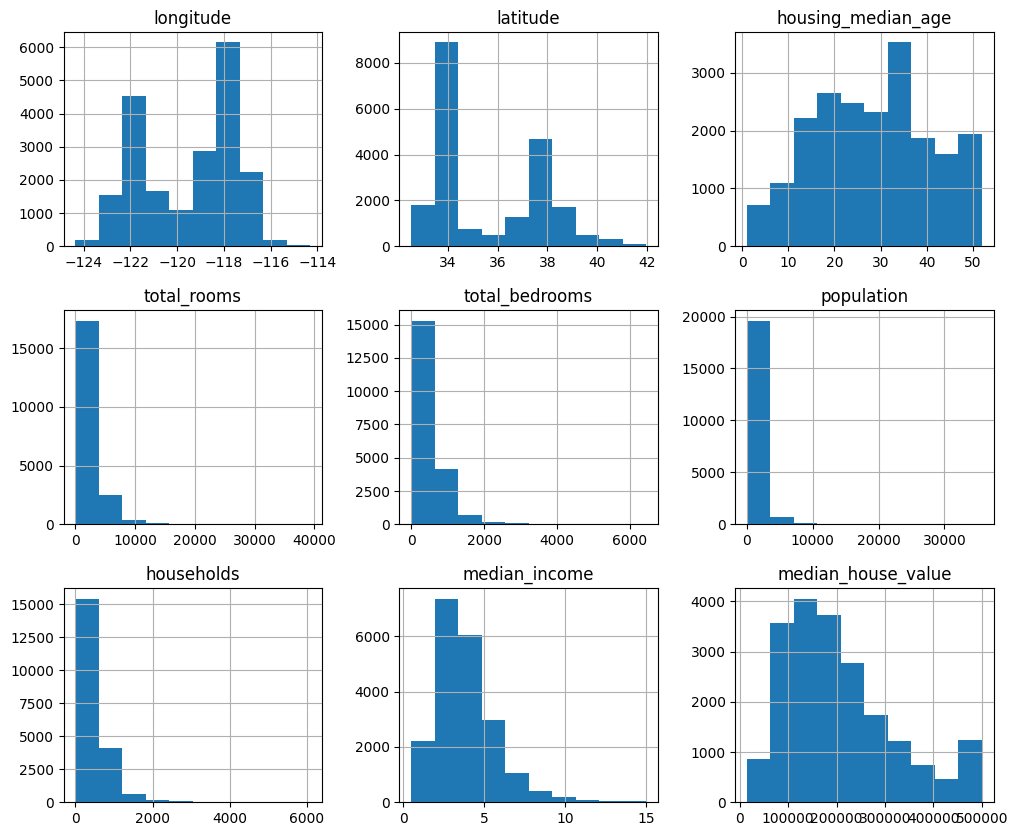

In [5]:
data.hist(figsize=[12, 10])

In [6]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
numeric_data.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,0.688355
median_house_value,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,1.000000


<Axes: >

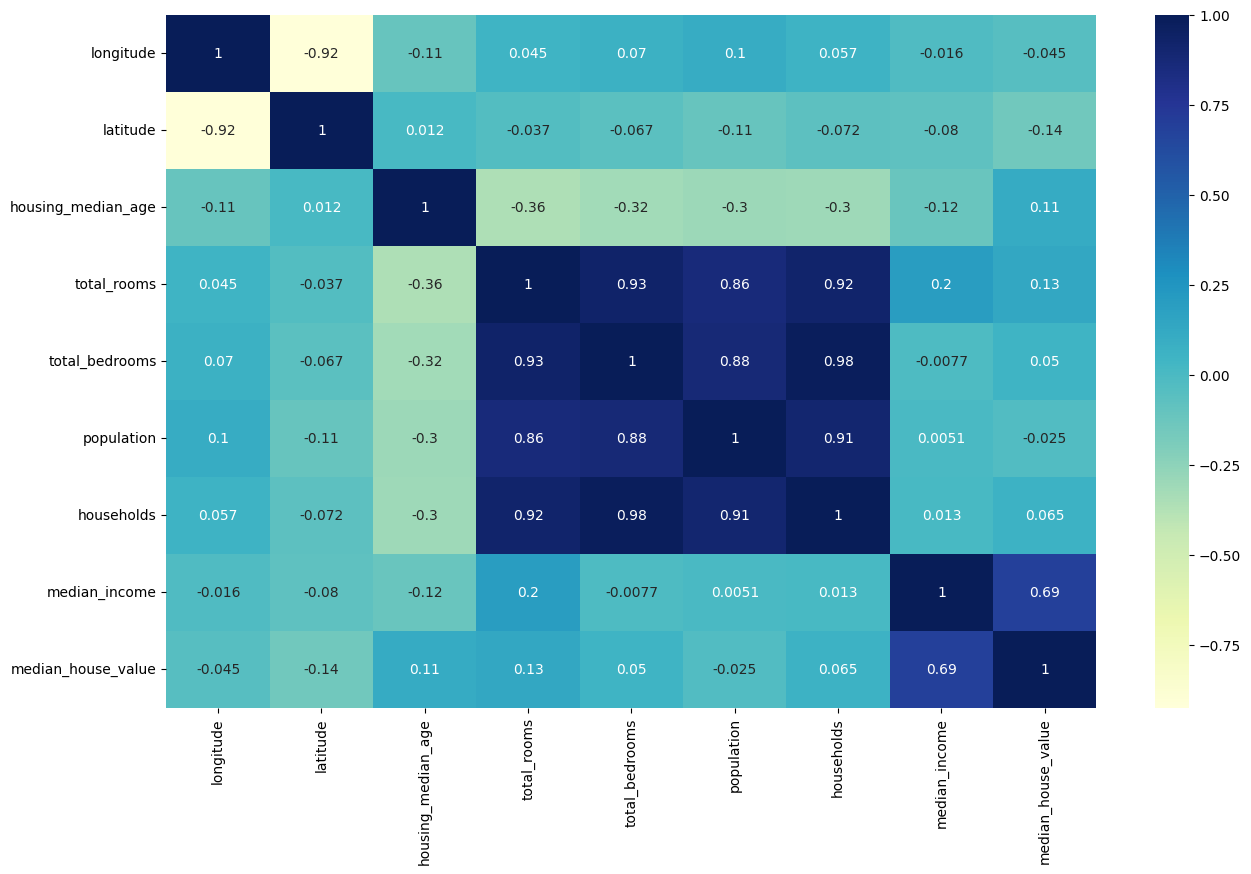

In [7]:
plt.figure(figsize=[15, 9])
sns.heatmap(numeric_data.corr(), annot = True, cmap='YlGnBu')

In [8]:
data['ocean_proximity'].value_counts()
data = data[data['ocean_proximity'] != 'ISLAND']

#one hot encoding for ocean proximity
data = pd.get_dummies(data, columns=['ocean_proximity'], dtype=int)



#### Removing one encoded column

In [9]:
# remvove one encoded column
encoded_columns = [col for col in data.columns if col.startswith('ocean_proximity_')]
column_sums = data[encoded_columns].sum()


baseline_column = column_sums.idxmax()
data.drop(baseline_column, axis=1, inplace=True)

<Axes: >

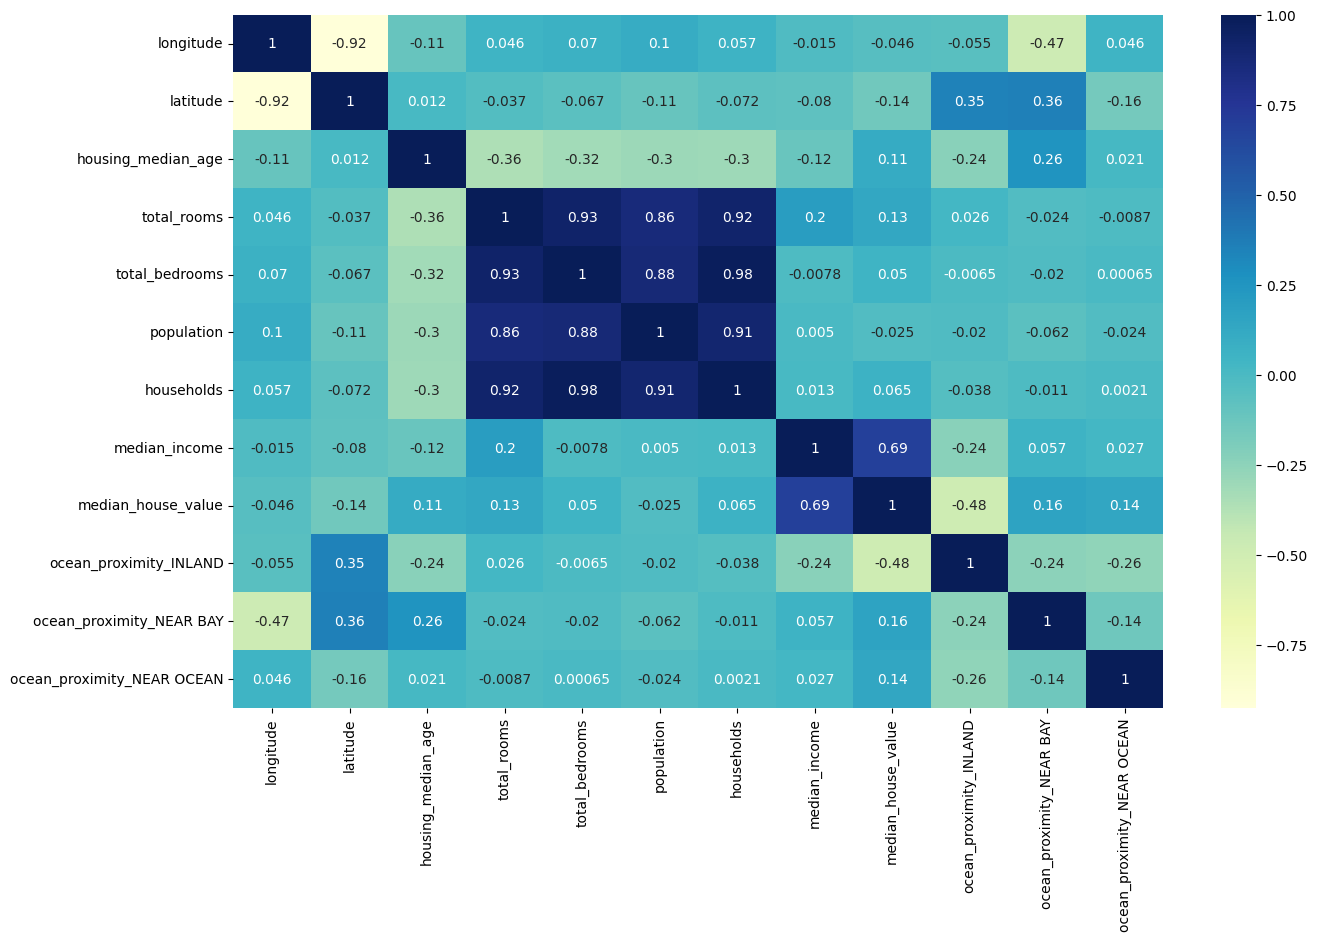

In [10]:
plt.figure(figsize=[15, 9])
sns.heatmap(data.corr(), annot = True, cmap='YlGnBu')

#### Feature Engineering

<Axes: xlabel='latitude', ylabel='longitude'>

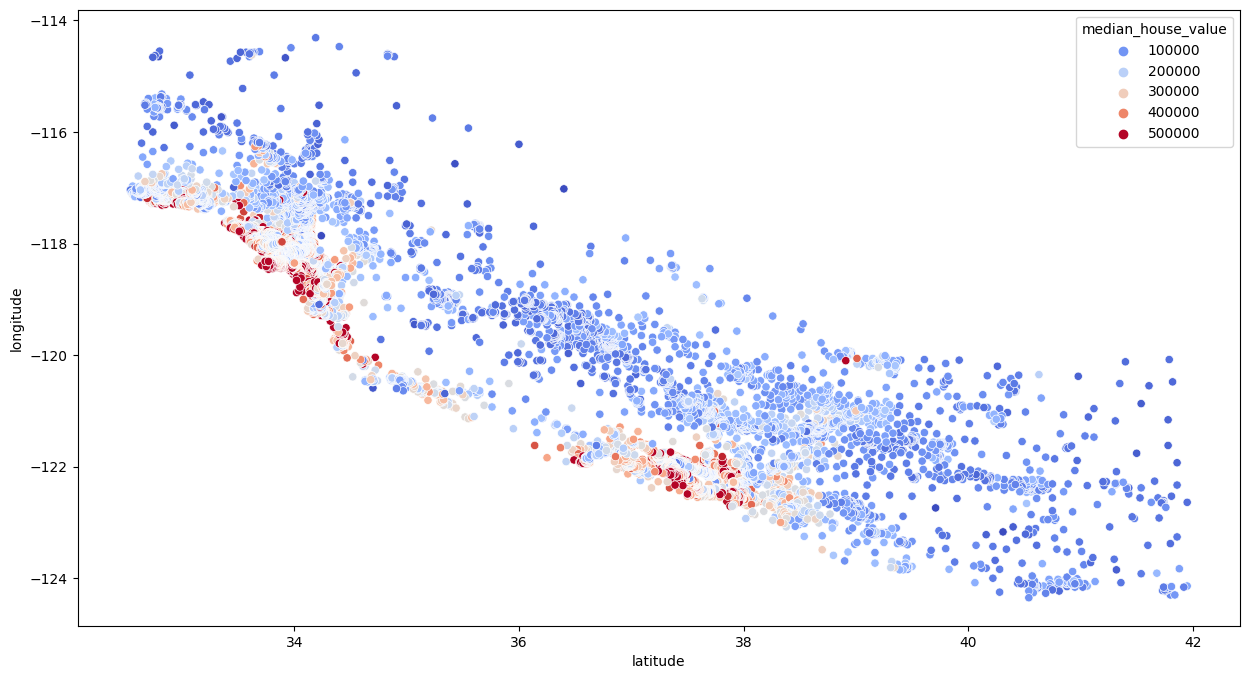

In [11]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='latitude', y='longitude', data=data, hue='median_house_value', palette='coolwarm')

#### Feature-engineering - Bedroom Ratio and room to person ratio

In [12]:
data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']
print('Total bedroom correlation ',data['total_bedrooms'].corr(data['median_house_value']), "vs bedroom ratio corr", data['bedroom_ratio'].corr(data['median_house_value']))

Total bedroom correlation  0.04979233616068897 vs bedroom ratio corr -0.2563973785818084


Hence bedroom ratio has a stronger influence than number of bedrooms, dropping total number of bedrooms

In [13]:
data.drop('total_bedrooms', axis=1, inplace=True)

In [14]:
#similarly we can look for room to person ratio rather than room count only
data['room_household_ratio'] = data['total_rooms'] / data['households']
print('Total rooms correlation ',data['total_rooms'].corr(data['median_house_value']), "vs room-persons ratio corr", data['room_household_ratio'].corr(data['median_house_value']))
#drop total_rooms
# data.drop('total_rooms', axis=1, inplace=True)

Total rooms correlation  0.1335159107870467 vs room-persons ratio corr 0.15136461608781035


In [15]:
# applying log transormation
cols_to_transform = ['population', 'households']
data[cols_to_transform] = np.log1p(data[cols_to_transform])

20428

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
reg1 = LinearRegression()
reg1.fit(X=x_train, y=y_train)

reg1.score(X=x_test, y=y_test)

0.6698382899293949

In [18]:
# reg = LinearRegression()
# reg.fit(X=x_train, y=y_train)

# reg.score(X=x_test, y=y_test)# Define the number of folds for cross-validation
num_folds = 6

# Create an instance of the linear regression model
reg = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(reg, x, y, cv=KFold(n_splits=num_folds, shuffle=True))


In [19]:
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

print("Mean cross-validation score:", mean_score)
print("Standard deviation of cross-validation scores:", std_score)

Mean cross-validation score: 0.6689375522486395
Standard deviation of cross-validation scores: 0.010580139970974987


#### Manually performing splits in order to get the accuracy using tolerance

In [50]:
LEN = len(data)

split_size = len(data) // num_folds
split_indices = [split_size * i for i in range(num_folds)] + [LEN]
tolerance = 80000

sum = 0
reg2 = LinearRegression()
for idx in range(len(split_indices)-1):
    start, end = split_indices[idx], split_indices[idx+1]
    X_test, Y_test = x.iloc[start:end], y.iloc[start:end]
    X_train, Y_train = pd.concat([x.iloc[:start], x.iloc[end:]]), pd.concat([y.iloc[:start], y.iloc[end:]])

    reg2.fit(X_train, Y_train)
    Y_pred = reg2.predict(X_test)
    
  
    for p, a in zip(Y_pred, Y_test):
        if p - a <= tolerance :
            sum += 1

acc = sum / LEN * 100
acc


    
    

89.94027804973565